### Table of Contents:
### 1. [Imports](#importing-files)
### 2. [Wrangle](#2-wrangle)
### 3. [Explore](#explore)
3a. [Exploring Continious Distributions](#explore-continious-distributions)\
3b. [Exploring Categorical Distributions](#explore-categorical-distributions)\
3c. [Exploring Correlations](#explore-correlations-with-similar-data)
### 4. [Modeling](#modeling)
4a. [Determining Baseline](#determining-baseline)\
4b. [Model 1: Logistic Regression](#model-1-logistic-regression)\
4c. [Model 1: Decision Tree](#model-2-decision-tree)\
4d. [Model 1: K Nearest Neighbor](#model-1-k-nearest-neighbor)
___
    

## Importing Files

In [1]:
# My .py Modularization Files
import env
import os
import wrangle as w
import modeling as m
import evaluate as e
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")
# Array and Dataframes
import numpy as np
import pandas as pd
# Evaluation: Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

___

## Wrangle (Acquire & Prepare)
*Completed before hand*

In [2]:
# Pull zillow from MySQL
zillow = w.zillow_post()

File exists, pulling from system.


#### Dropped where bathroom and bedroom counts were 0. Changes to column names. County was modified to show name instead of just fib code.

In [3]:
# Preview
zillow.sample(5)

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,garagetotalsqft,fireplacecnt,orange,ventura
54232,4,3.0,1935,202810,1978,Ventura,504.0,1.0,0,1
523,3,2.0,1440,117030,1973,Ventura,483.0,1.0,0,1
54403,5,2.5,2979,405772,1975,Ventura,593.0,1.0,0,1
11560,5,2.5,2532,835948,1968,Ventura,611.0,1.0,0,1
54557,4,3.0,3380,736065,1988,Ventura,754.0,3.0,0,1


In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7545 entries, 52 to 54589
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroomcnt       7545 non-null   int64  
 1   bathroomcnt      7545 non-null   float64
 2   sq_feet          7545 non-null   int64  
 3   tax_value        7545 non-null   int64  
 4   yearbuilt        7545 non-null   int64  
 5   county           7545 non-null   object 
 6   garagetotalsqft  7545 non-null   float64
 7   fireplacecnt     7545 non-null   float64
 8   orange           7545 non-null   int64  
 9   ventura          7545 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 648.4+ KB


In [5]:
# Will be used to elimate outliers
zillow = zillow[zillow.tax_value < 2000000]
# shape is 7545, 10 before this filter
# and 7471, 10 losing only a small piece of outliers

In [6]:
zillow.shape 


(7471, 10)

In [7]:
w.summarize(zillow)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,dtype
5,county,2,"[Ventura, Orange]",0,object
8,orange,2,"[0, 1]",0,int64
9,ventura,2,"[1, 0]",0,int64
7,fireplacecnt,6,"[1.0, 2.0, 4.0, 3.0, 5.0, 9.0]",0,float64
0,bedroomcnt,8,"[2, 3, 4, 5, 1, 6, 7, 8]",0,int64
1,bathroomcnt,15,"[1.0, 2.0, 3.0, 2.5, 4.0, 3.5, 5.0, 1.5, 4.5, 0.0, 5.5, 6.5, 6.0, 9.0, 8.0]",0,float64
4,yearbuilt,103,"[1971, 1950, 1961, 1967, 1981, 1966, 1960, 1982, 1973, 1995, 1979, 1958, 1947, 1954, 1...",0,int64
6,garagetotalsqft,594,"[400.0, 220.0, 437.0, 460.0, 500.0, 636.0, 552.0, 396.0, 784.0, 704.0, 0.0, 484.0, 475...",0,float64
2,sq_feet,2327,"[780, 1404, 1505, 2025, 1620, 2148, 2840, 3541, 3760, 1440, 2468, 2261, 1197, 1411, 10...",0,int64
3,tax_value,6798,"[88731, 313844, 604790, 450938, 369463, 680000, 610795, 933239, 872850, 391993, 517877...",0,int64


In [8]:
# seperate data for training, validation and testing
train, validate, test = w.splitter(zillow)

Dataframe: (7471, 10) 100%
Train: (4780, 10) | ~60%
Validate: (1196, 10) | ~20%
Test: (1495, 10) | ~20%


In [9]:
# view all columns with associated values to observe
pd.set_option('display.max_columns', None)

___

## Explore: Hypothesis 
- Are the number of bedrooms 


## Explore: Feature Engineer

In [10]:
# organize columns is a function to seperate columns from catergorical to numerical data types
cat_cols, num_cols = w.organize_columns(train)

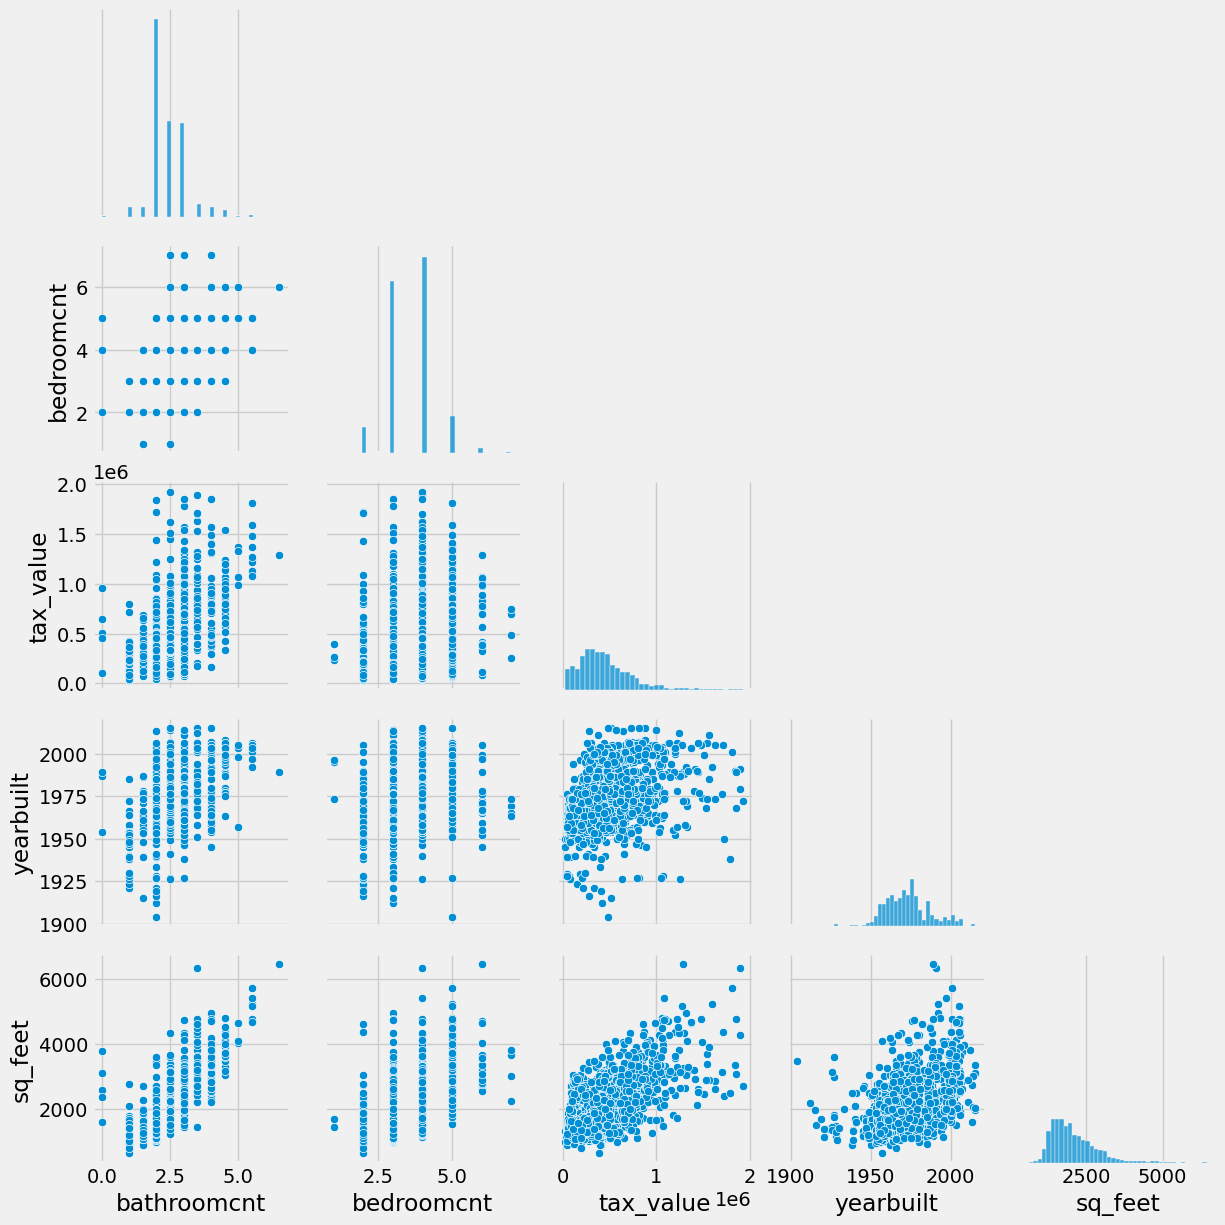

In [11]:
sns.pairplot(train[['bathroomcnt','bedroomcnt','tax_value','yearbuilt','sq_feet']].sample(2000), corner=True)

## Explore: Categorical Distributions

In [12]:
# compiling categorical columns
cat_cols = train[['county']]

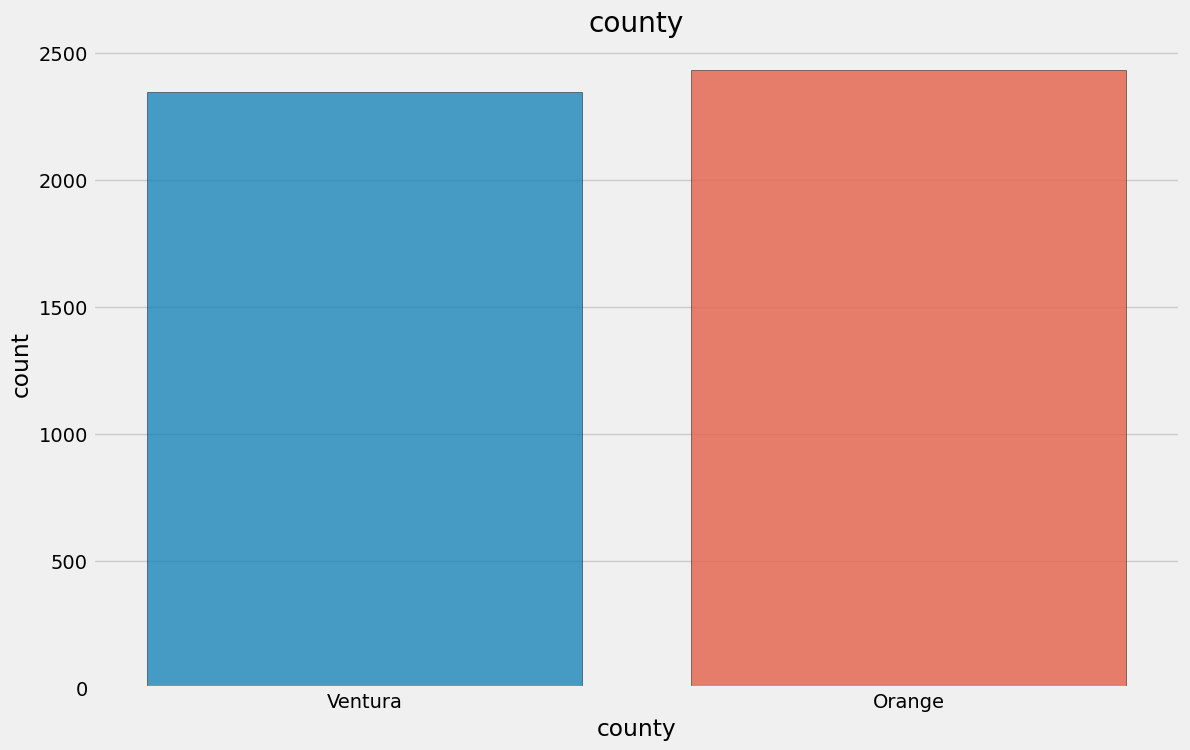

-------------------------------------------------------------


In [13]:
# Function to loop through desired df and respective columns to visualize 
w.check_cat_distribution(cat_cols)

## Explore: Continious Distributions

Text(0.5, 1.0, 'Tax Value After Filter')

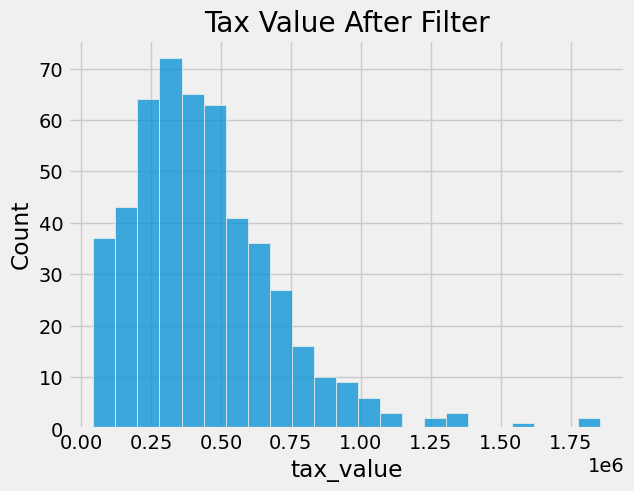

In [14]:
sns.histplot(data=train.sample(500),x='tax_value')
plt.ticklabel_format(style='sci', axis='x')
plt.title('Tax Value After Filter')

In [15]:
# compiling continious columns
num_cols = train[num_cols]

In [16]:
# Loop through respective df and column
#w.check_num_distribution(num_cols.sample(100),dataset=train)

#### A negative correlation between tenure and churn can be observed

## Explore: Correlations with Similar Data

In [17]:
zillow.head()

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,garagetotalsqft,fireplacecnt,orange,ventura
54,2,1.0,780,88731,1971,Ventura,400.0,1.0,0,1
56,2,1.0,1404,313844,1950,Ventura,220.0,2.0,0,1
57,3,2.0,1505,604790,1961,Ventura,437.0,1.0,0,1
59,4,3.0,2025,450938,1961,Ventura,460.0,2.0,0,1
60,4,2.5,1620,369463,1967,Ventura,500.0,1.0,0,1


**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **not** linear correlation between *tax_value* &  *bedroomcnt*\
Null $H_a$: There *is* linear correlation between *tax_value* &  *bedroomcnt*

In [18]:
# conduct statistical analysis of churn x contract_type_month_to_month
e.check_correlation(feature= train.tax_value, compare = train.bedroomcnt)

NOT a normal distribution, spearman r
Reject the null hypothesis. There is a linear correlation.
        Pearson's r: 0.199380
        P-value: 4.719898027978113e-44


**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **not** a linear correlation between *tax_value* & *bathroomcnt*\
Null $H_a$: There *is not* a linear correlation between *tax_value* & *bathroomcnt*

In [19]:
e.check_correlation(feature= train.tax_value, compare = train.bathroomcnt)

NOT a normal distribution, spearman r
Reject the null hypothesis. There is a linear correlation.
        Pearson's r: 0.420424
        P-value: 4.323448820083984e-204


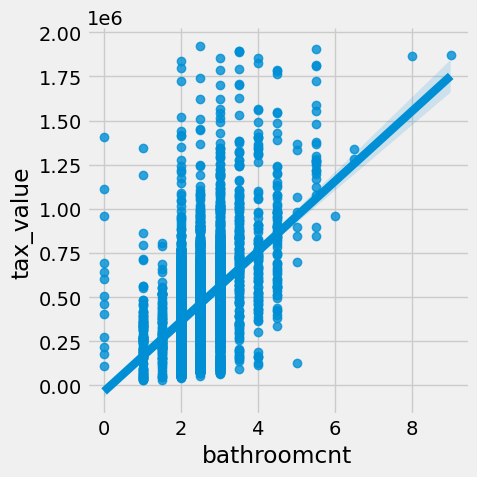

In [20]:
sns.lmplot(data=train,x='bathroomcnt',y='tax_value')

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There **is not** a linear correlation between *tax_value* & *sq_feet*\
Null $H_a$: There *is* a linear correlation between *tax_value* & *sq_feet*

In [21]:
e.check_correlation(feature= train.tax_value, compare = train.sq_feet)

NOT a normal distribution, spearman r
Reject the null hypothesis. There is a linear correlation.
        Pearson's r: 0.478614
        P-value: 2.875119377462356e-272


<Axes: xlabel='tax_value'>

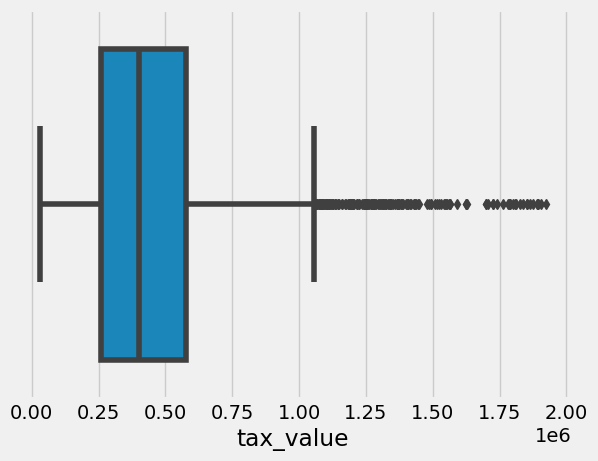

In [22]:
sns.boxplot(data=train, x='tax_value')

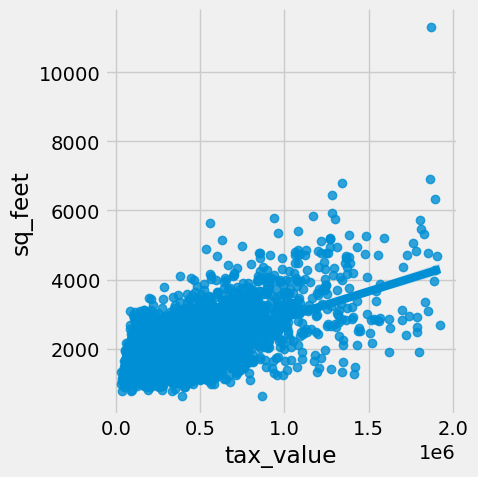

In [23]:
sns.lmplot(data=train,x='tax_value',y='sq_feet')

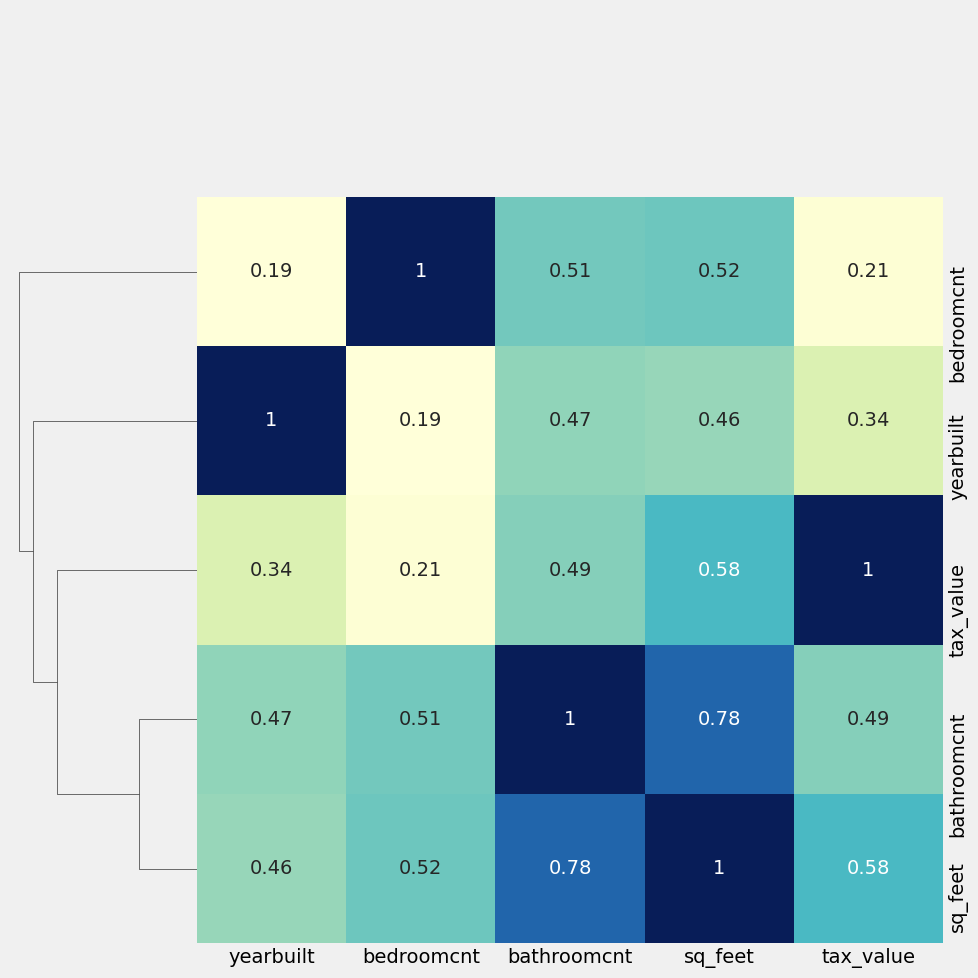

In [24]:
# Clustering correlation grid comparison

# Exploring binary categorical data as well as our two continious values -- total_charges & monthly_charges
zillow_grid = train[['yearbuilt','bedroomcnt','bathroomcnt','sq_feet','tax_value']]
sns_plot = sns.clustermap(zillow_grid.corr(),cmap = 'YlGnBu',annot=True,col_cluster=False)
sns_plot.cax.set_visible(False)
plt.title('Correlations Between Features')
plt.show()

# Modeling

## Features Selected
___
- **target** - continious - tax value
- continious - bedroomcnt
- continious - bathroomcnt
- continious - sq_feet

## Determining Baseline

In [25]:
train['bedroomcnt'].value_counts(0)

bedroomcnt
4    2122
3    1878
5     429
2     278
6      55
1      10
7       7
8       1
Name: count, dtype: int64

In [26]:
train.head()

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,garagetotalsqft,fireplacecnt,orange,ventura
11057,5,3.0,2531,128793,1966,Ventura,504.0,1.0,0,1
32909,3,2.0,1641,288541,1975,Ventura,441.0,1.0,0,1
41729,3,2.0,1633,123052,1968,Orange,439.0,1.0,1,0
50906,3,2.0,1187,211781,1957,Orange,456.0,1.0,1,0
22054,3,2.0,1661,114815,1978,Ventura,460.0,1.0,0,1


In [27]:
x_train = train[['bedroomcnt','bathroomcnt','sq_feet']]
y_train = train['tax_value']

x_validate = validate[['bedroomcnt','bathroomcnt','sq_feet']]
y_validate = validate['tax_value']

x_test = test[['bedroomcnt','bathroomcnt','sq_feet']]
y_test = test['tax_value']

In [28]:
# Set baseline & array for baseline predictions
baseline, baseline_array = m.find_baseline(train, y_train)
baseline

448303.57238493726

In [29]:
baseline_rmse, baseline_r2 = m.regression_metrics(y_train, baseline_array)

In [30]:
metrics_df = m.metrics_dataframe(model='baseline', RMSE=baseline_rmse, R2=baseline_r2)

## Scale Data

Data is scalled 'Robust' due to large data set and numerous outliers

In [31]:
x_train_scaled, x_validate_scaled, x_test_scaled = w.QuickScale(x_train, x_validate, x_test, linear=True, scaler='Robust')

## Find Best Features

In [32]:
best_features = m.rfe(x_train_scaled=x_train_scaled, x_train=x_train,y_train=y_train, model='glm2',k=3)
best_features

['bedroomcnt', 'bathroomcnt', 'sq_feet']

In [33]:
k_features = m.select_kbest(x_train_scaled,x_train, y_train, k=3)
k_features

['bedroomcnt', 'bathroomcnt', 'sq_feet']

## Model 1: OLS - Ordinary Least Squares

In [34]:
ols_rmse, ols_r2, ols_predictions, ols_val_predictions = m.OLS(x_train_scaled, y_train, x_validate_scaled,  y_validate)

RMSE: 214638.6375793407
R2: 0.39653107495459416
Intercept: 371974.92872683663
Coefficient: -53474.80312189158


In [35]:
m.save_metrics(df=metrics_df,model='ols',RMSE=ols_rmse,R2=ols_r2)

,model,rmse,r2
0,baseline,281422.976636,0.000000
1,ols,214638.637579,0.396531


In [36]:
len(x_train_scaled[:,1])

4780

In [37]:
ols_residuals = x_train_scaled[:,1] - ols_predictions

<Axes: ylabel='tax_value'>

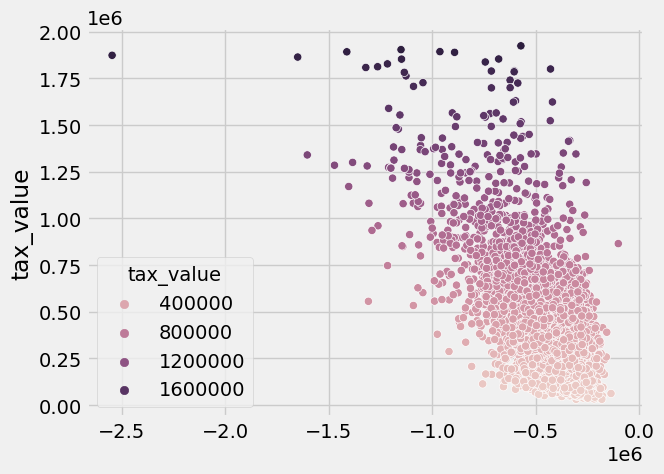

In [38]:
sns.scatterplot(data = train,x = ols_residuals, y = y_train, hue = y_train)

## Model 1: LassoLars

In [39]:
lassolars_rmse, lassolars_r2, lassolars_predictions, lassolars_val_predictions = m.Lars(x_train_scaled, y_train, x_validate_scaled, y_validate,alpha=1)

RMSE: 214638.69947511388
R2: 0.3965307269074625
Intercept: 371977.90420312615
Coefficient: -53471.17529519892


In [40]:
m.save_metrics(df=metrics_df,model='lassolars',RMSE=lassolars_rmse,R2=lassolars_r2)

,model,rmse,r2
0,baseline,281422.976636,0.000000
1,ols,214638.637579,0.396531
2,lassolars,214638.699475,0.396531


## Model 1: Polynomial

In [41]:
poly_rmse, poly_r2,poly_predictions, poly_val_predictions = m.Polynom(x_train, y_train, x_validate_scaled, y_validate)

RMSE: 427459.8495858582
R2: -1.3934797789214075
Intercept: 74663.25688376155
Coefficient: -53474.803121892764


In [42]:
m.save_metrics(df=metrics_df,model='poly',RMSE=poly_rmse,R2=poly_r2)

,model,rmse,r2
0,baseline,281422.976636,0.000000
1,ols,214638.637579,0.396531
2,lassolars,214638.699475,0.396531
3,poly,427459.849586,-1.393480


## Model 1: Generalized Linear Model ( Gamma )

In [43]:
glm_rmse, glm_r2,glm_predictions, glm_val_predictions = m.GLM(x_train, y_train, x_validate, y_validate,  power=2)

RMSE: 214681.9118981121
R2: 0.3962877139317995
Intercept: 12.158527302980453
Coefficient: -0.02461705058081674


In [44]:
m.save_metrics(df=metrics_df,model='glm_gamma',RMSE=glm_rmse,R2=glm_r2)

,model,rmse,r2
0,baseline,281422.976636,0.000000
1,ols,214638.637579,0.396531
2,lassolars,214638.699475,0.396531
3,poly,427459.849586,-1.393480
4,glm_gamma,214681.911898,0.396288


In [50]:
e.plot_residuals(train, x_train, y_train, yhat = glm_val_predictions, baseline = baseline_array)

ValueError: Unable to coerce to Series, length must be 3: given 1196

## Model 1: Generalized Linear Model ( Inverse Gaussian )

In [ ]:
glm_rmse, glm_r2,glm_predictions, glm_val_predictions = m.GLM(x_train, y_train, x_validate, y_validate,  power=3)

RMSE: 270565.0571985392
R2: 0.041079680966969456
Intercept: 13.013225885656178
Coefficient: -2.1136185614552547e-08


In [ ]:
m.save_metrics(df=metrics_df,model='glm_inverse_gaussian',RMSE=glm_rmse,R2=glm_r2)

,model,rmse,r2
0,baseline,281422.976636,0.000000
1,ols,214638.637579,0.396531
2,lassolars,214638.699475,0.396531
3,poly,427459.849586,-1.393480
4,glm_gamma,214681.911898,0.396288
5,glm_inverse_gaussian,270565.057199,0.041080
